In [1]:
from typing import Tuple, Optional
from data.hysteresis import hysteresis_ode
from data.utils import _load_wrapper
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import torch

from scipy.integrate import solve_ivp

In [2]:
def simulate_steady_state(
    lam_values, 
    x0, 
    t_span:Tuple[float, float],
    t_eval: Optional[np.ndarray] = None,
    show_progress: bool = True,
    device:str = 'cpu'
)-> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    lam_values: control params 
    x0: initial state observation
    t_span: start and stop time of ode solution 
    t_eval: Points at which to save results. Default is end of t_span.
    show_progress: Show progress bar (tqdm)
    
    """
    wrapper = _load_wrapper(show_progress)

    x_curr = np.array([x0])
    
    if t_eval is None:
        t_eval = np.array([t_span[-1]])
    
    for idx, lam in enumerate(wrapper(lam_values)):
        sol = solve_ivp(
            hysteresis_ode, 
            t_span=t_span, 
            y0=x_curr, 
            args=(lam,), 
            t_eval=t_eval
        )

        x_curr = sol.y[:, -1]  # final value

        lam_i = np.array([lam]*len(t_eval))
        
        if idx == 0:
            x_vals = sol.y
            lam_vals = lam_i
            t_vals = t_eval
        
        else:
            x_vals = np.hstack((x_vals, sol.y[:,1:]))
            lam_vals = np.hstack((lam_vals,lam_i[1:]))
            t_vals = np.hstack((t_vals,t_eval[1:] + t_eval[-1]*idx))

    x_vals = torch.tensor(x_vals, dtype=torch.float32,device=device)
    lam_vals = torch.tensor(lam_vals, dtype=torch.float32,device=device)    
    t_vals = torch.tensor(t_vals, dtype=torch.float32,device=device)
    return x_vals, lam_vals, t_vals


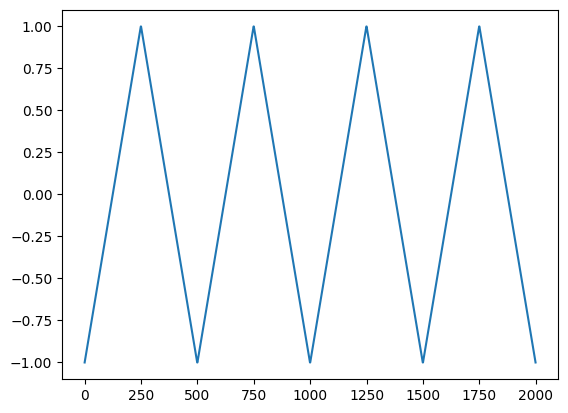

In [110]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

lam = np.hstack((lam_increase,lam_decrease))
repeat = 2
for _ in range(repeat):
    lam = np.hstack((lam, lam))
plt.plot(lam)

In [4]:
t_eval = np.linspace(0,50,301)
# t_eval = None
x0s = np.linspace(-1.6, -1., 101)
Xs = []
for x0 in tqdm(x0s):
    Xi, lams, T = simulate_steady_state(lam, x0, t_span=[0,50], t_eval=t_eval, show_progress=False)
    Xs.append(Xi)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

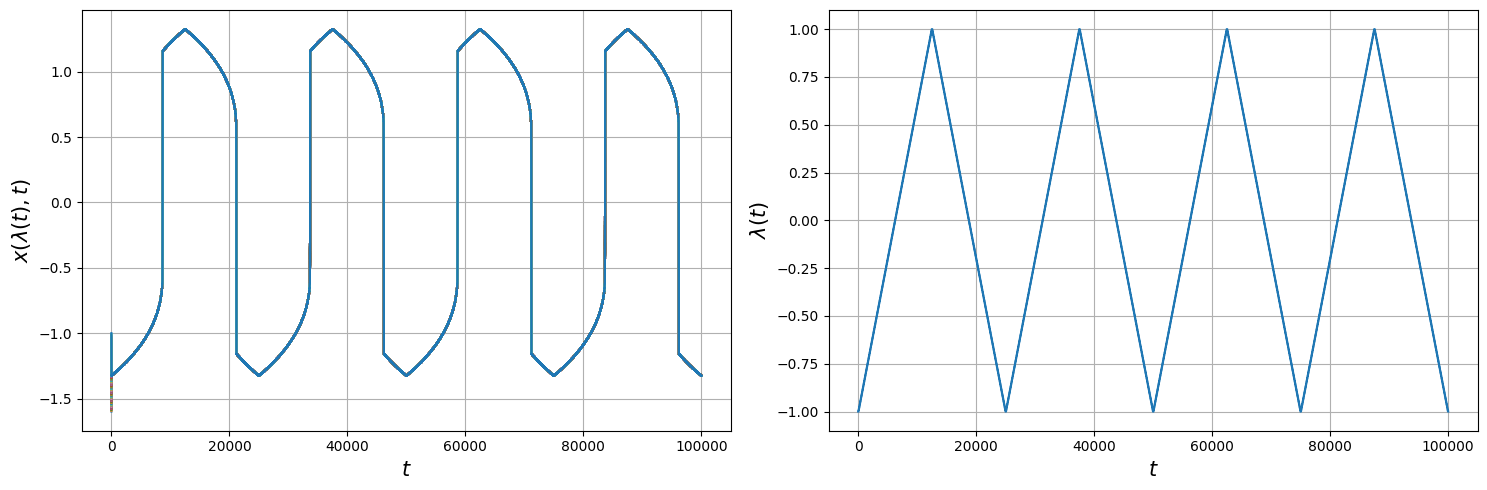

In [13]:
cutoff = -1
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))
for idx, x0 in enumerate(tqdm(x0s)):
    ax1.plot(T[:cutoff], Xs[idx][0, :cutoff], label=rf"$x_0$ = {x0:.3f}")
ax1.set_xlabel(r"$t$", size=15)
ax1.set_ylabel(r"$x(\lambda(t),t)$",size=15)
# ax1.legend(prop={'family': 'serif'})
ax1.grid(True)
# ax1.set_yscale('log')
ax2.plot(T[:cutoff], lams[:cutoff])
ax2.grid(True)
ax2.set_xlabel(r"$t$", size=15)
ax2.set_ylabel(r"$\lambda(t)$",size=15)
plt.tight_layout()
# plt.savefig(f"x0_pertubations_{len(x0s)}.png")
plt.savefig(f"x0_pertubations_{len(x0s)}.png")
plt.show()

  0%|          | 0/101 [00:00<?, ?it/s]

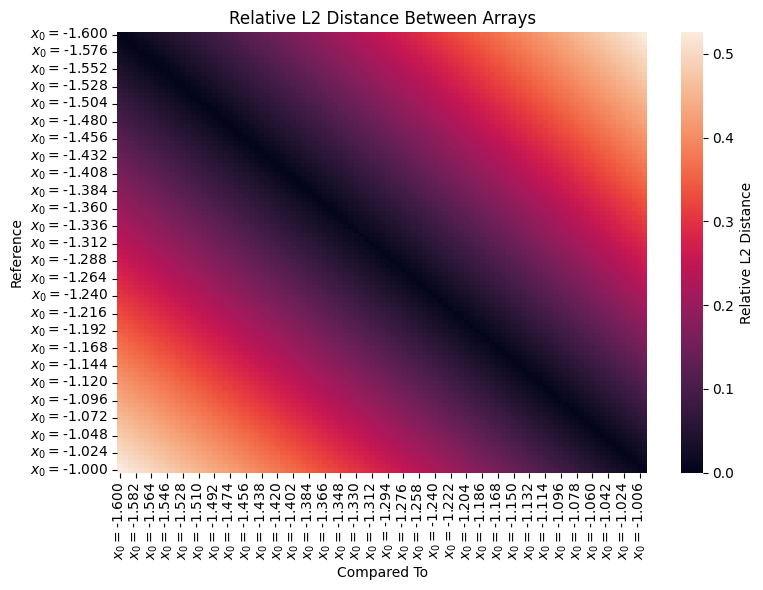

In [16]:
l2_rel_err = lambda x,y: np.linalg.norm(x-y) / np.var(x)
names = [rf"$x_0=${x0:.3f}" for x0 in x0s]
series = pd.Series(Xs, index =names)
dist_df = pd.DataFrame(index=names, columns=names, dtype=float)
for i in tqdm(names):
    for j in names:
        dist_df.loc[i,j] = l2_rel_err(series[i], series[j])

fig, ax = plt.subplots(1,1, figsize = (8,6))
sns.heatmap(dist_df, annot=False, fmt=".4f", cmap="rocket", cbar_kws={'label': 'Relative L2 Distance'})
plt.title("Relative L2 Distance Between Arrays")
plt.xlabel("Compared To")
plt.ylabel("Reference")
plt.tight_layout()
plt.savefig(f"l2_err_heatmap_x0_perturbations_{len(x0s)}_var.png")
plt.show()


## update dataloader

In [3]:
import torch
import numpy as np
from stabnode.node import StabNODE, Felu, Gelu, set_global_seed, model_trainer
from torchdiffeq import odeint
import torch.nn as nn

In [4]:
set_global_seed(1234)

In [5]:
class TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, X, t, window_size):
        self.X = X              # shape [T_total, d]
        self.t = t              # shape [T_total]
        self.window_size = window_size

    def __len__(self):
        return len(self.X) - self.window_size

    def __getitem__(self, idx):
        x0 = self.X[idx]                                          
        t_window = self.t[idx : idx + self.window_size]           
        x_window = self.X[idx : idx + self.window_size]           

        return x0, t_window, x_window

In [6]:
lam_start = -1 
lam_end = 1

x0=-1.3
n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

lam = np.hstack((lam_increase,lam_decrease))

t_eval = np.linspace(0,10,101)

In [7]:
Xi, lams, T = simulate_steady_state(lam, x0, t_span=[0,10], t_eval=t_eval, show_progress=True)

  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
Xi

tensor([[-1.3000, -1.3085, -1.3143,  ..., -1.3246, -1.3246, -1.3246]])

In [9]:
# def control_func(t:torch.tensor):
#     t = t.squeeze()
#     idx = np.where(np.isclose(T,t))[0]
#     return lams[idx]

from scipy.interpolate import interp1d

interp_lam = interp1d(T, lams.numpy(), axis=0, kind='linear')

def control_func(t: torch.Tensor):
    t_scalar = t.item()
    lam_t = torch.tensor(interp_lam(t_scalar), dtype=torch.float32)
    return lam_t.unsqueeze(0)


In [10]:
control_func(torch.tensor(200))

tensor([-0.8474])

In [11]:
train_dataset = TrajectoryDataset(Xi.reshape(-1), T, window_size=100)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

In [12]:
len(train_loader)

500

In [13]:
f = Felu(dim_in=1,dim_out=1, hidden_dim=4)
g = Gelu(dim_in=2, dim_out=1, hidden_dim=2)
model = StabNODE(f,g)

In [14]:
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = 0.1)
loss_criteria = nn.MSELoss()

model.train()

losses = []
for idx, (x0_batch, t_batch, x_true_batch) in enumerate(tqdm(train_loader)):
    opt.zero_grad()
    
    x_pred = []
    for x0_i, t_i in zip(x0_batch, t_batch):
        x_pred_i = odeint(
            func=lambda t, x: model(t, x, control_func),
            y0=x0_i.reshape(-1, 1),
            t=t_i,
            method='rk4'
        ).squeeze()
        x_pred.append(x_pred_i)

    x_pred = torch.stack(x_pred, dim=0) 

    loss = loss_criteria(x_pred.squeeze(), x_true_batch.squeeze())
    loss.backward()
    opt.step()

    losses.append(loss.item())

    # if idx == 0:
    #     x0s = x0_batch
    #     ts = t_batch
    #     xs = x_true_batch
    #     x_pred = odeint(
    #         func = lambda t, x: model(t,x, control_func),
    #         y0=x0s[0].reshape(-1,1),
    #         t=ts[0],
    #         method='rk4'
    #     ).squeeze()
        # print(xs[0].shape)
        # print(x_pred.shape)
        # print(torch.linalg.norm(x_pred - xs[0])/torch.linalg.norm(xs[0]))


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

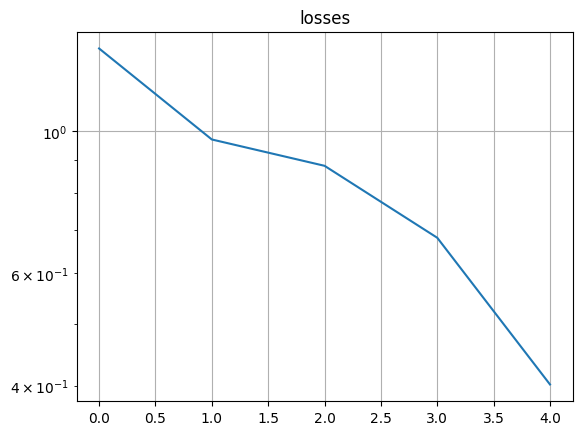

In [19]:
plt.plot(losses)
plt.title("losses")
plt.grid(True)
plt.yscale('log')

In [ ]:
x_true_batch.shape, t_batch.shape, x0_batch.shape

(torch.Size([1, 100]), torch.Size([1, 100]), torch.Size([1]))

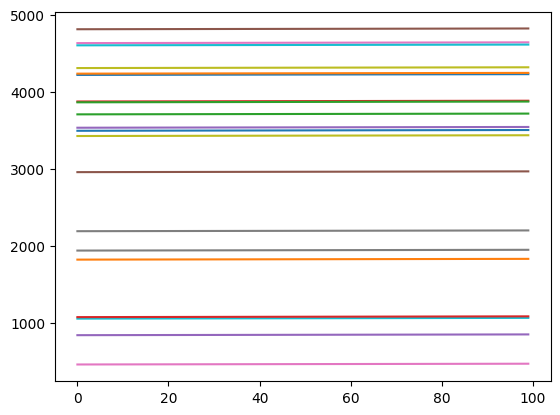

In [50]:
for ti in ts:
    plt.plot(ti)
# plt.yscale("log")
plt.show()

In [45]:
torch.linalg.norm(x_pred-xs) / torch.linalg.norm(xs)

tensor(0.9921, grad_fn=<DivBackward0>)